![image.png](https://i.imgur.com/a3uAqnb.png)

# Introduction to Neural Networks

In this lab we will:
- Load a real chemistry dataset (molecular descriptors ➜ solubility).
- Build a neural network from scratch using only NumPy.
- Train it with gradient descent.
- Evaluate how well it predicts aqueous solubility (`logS`).

Key ideas:
1. Forward pass (prediction)
2. Loss (error)
3. Backpropagation (gradients)
4. Weight update (learning)


# Importing Required Libraries

In this step, we import all the essential Python libraries we’ll use throughout the lab:

- **NumPy** → for numerical computations and array manipulation  
- **Pandas** → for loading and handling the dataset  
- **Matplotlib** → for visualizing loss curves and predictions  
- **Seaborn** → for creating clean, styled plots  

These libraries form the foundation of most AI and data analysis workflows.


In [201]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Chemistry Dataset

We'll now load our dataset containing **molecular descriptors** and their measured **aqueous solubility** values (`logS`).

Each row represents one molecule and includes:

- `MolLogP`: Hydrophobicity (how soluble a compound is in fat vs. water)  
- `MolWt`: Molecular Weight  
- `NumRotatableBonds`: Molecular flexibility  
- `AromaticProportion`: Ratio of aromatic atoms in the molecule  
- `logS`: Experimental solubility in water — this is our **target** to predict  

We'll use Pandas to read the data directly from a public CSV file hosted on GitHub.


In [202]:
# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/dataprofessor/data/master/delaney_solubility_with_descriptors.csv')
data.head()

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.5954,167.850,0.0,0.0,-2.18
1,2.3765,133.405,0.0,0.0,-2.00
2,2.5938,167.850,1.0,0.0,-1.74
3,2.0289,133.405,1.0,0.0,-1.48
4,2.9189,187.375,1.0,0.0,-3.04


# Exploratory Data Analysis (EDA)

Before training our neural network, let’s take a closer look at the **structure and relationships** within our dataset.

We’ll explore three key aspects:

### 1️⃣ Correlation — Understanding Feature Relationships
We use **Pearson’s correlation coefficient** to examine how strongly each molecular descriptor relates to others and to the target variable `logS` (solubility):
- Values near **+1** → strong positive relationship  
- Values near **–1** → strong negative relationship  
- Values near **0** → little or no linear relationship  

This helps us see which descriptors might be most informative for predicting solubility.

---

### 2️⃣ Skewness — Checking Data Symmetry
**Skewness** measures how symmetric or stretched a distribution is:
- **0** → perfectly symmetric  
- **Positive skew** → tail extends to the right  
- **Negative skew** → tail extends to the left  

Skewed features may need normalization to stabilize training.

---

### 3️⃣ Visualizing Feature Distributions
Finally, we’ll plot **histograms** for all numeric features to visually inspect:
- Data spread  
- Presence of outliers  
- General shape of each feature distribution  

These insights guide our preprocessing and help ensure stable neural network learning.


In [203]:
# correlation: Pearson’s by default
data.corr(method='pearson')

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
MolLogP,1.000000,0.468097,0.205607,0.250977,-0.827959
MolWt,0.468097,1.000000,0.394219,0.098855,-0.637324
NumRotatableBonds,0.205607,0.394219,1.000000,-0.296737,-0.238508
AromaticProportion,0.250977,0.098855,-0.296737,1.000000,-0.268108
logS,-0.827959,-0.637324,-0.238508,-0.268108,1.000000


In [204]:
# skew
data.skew()

,0
MolLogP,-0.012982
MolWt,0.890477
NumRotatableBonds,2.158178
AromaticProportion,0.226302
logS,-0.484590


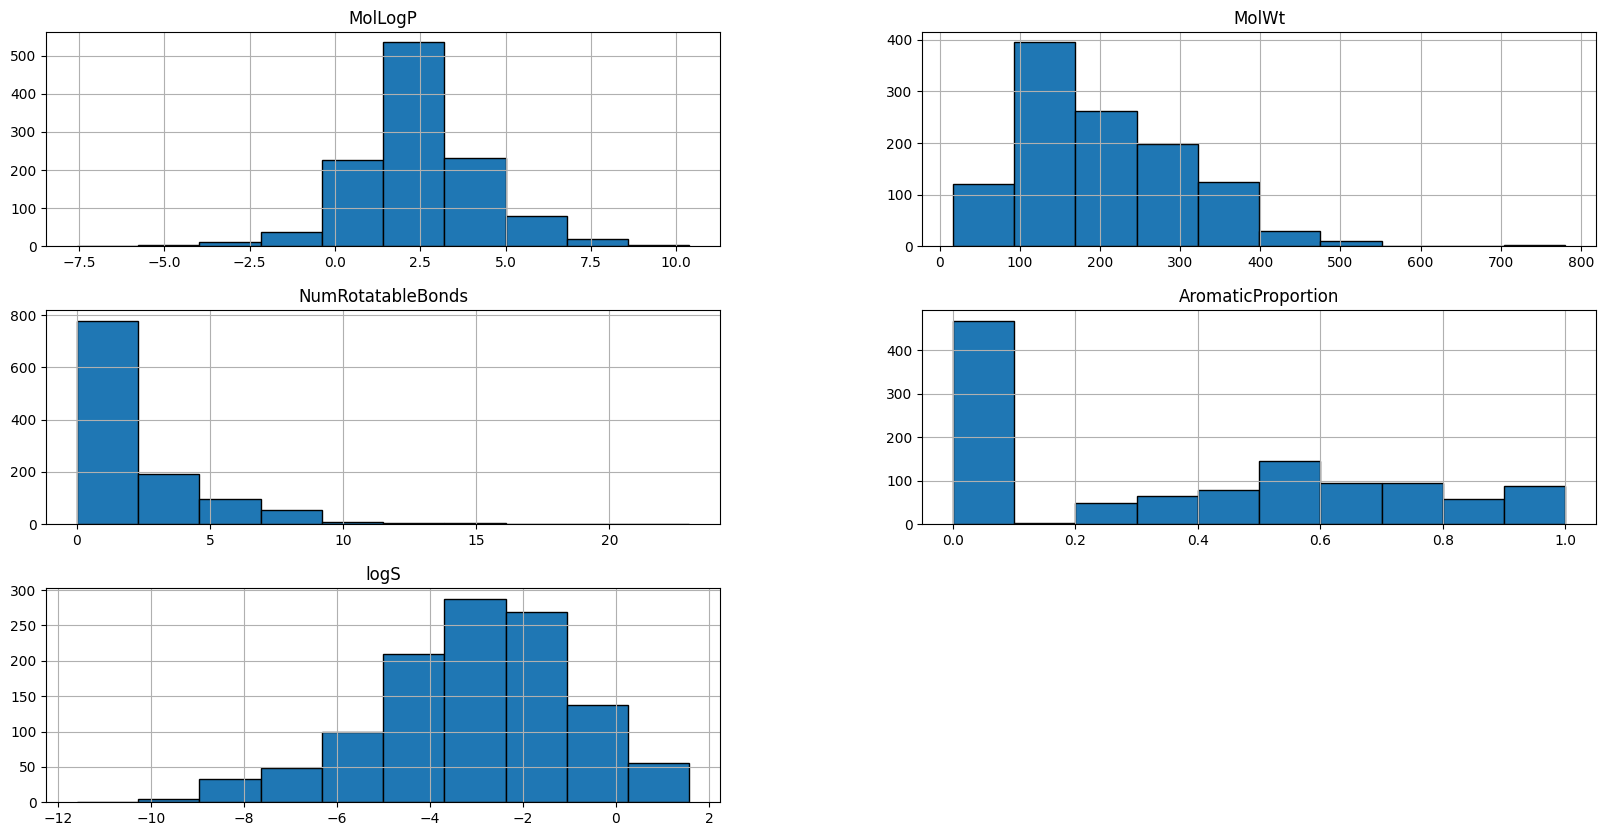

In [205]:
# Univariate distributions with histogram
data.hist(figsize=(20,10), edgecolor='black')
plt.show()

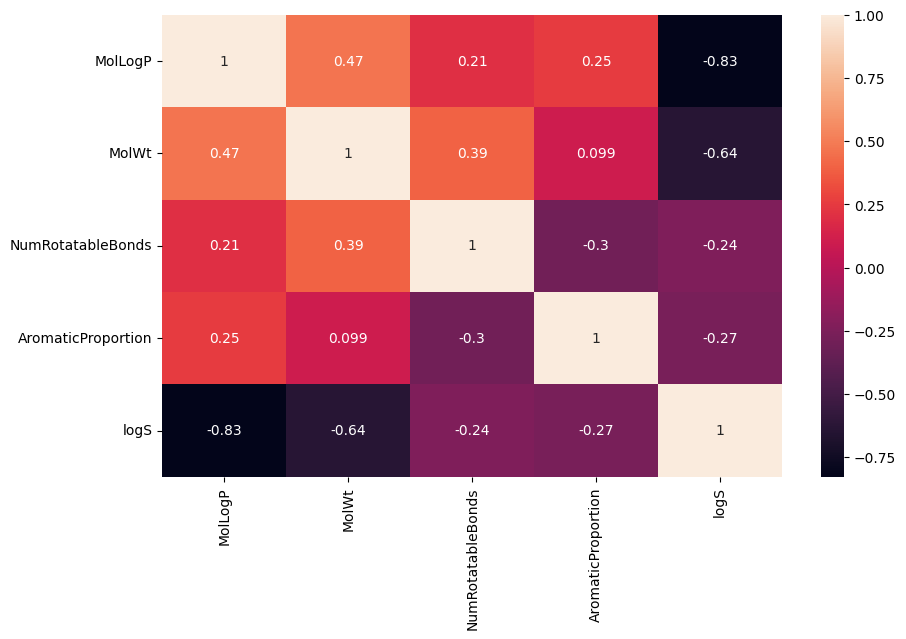

In [206]:
# Multivariate plots with correlations
plt.figure(figsize=(10,6))
corr = data.corr()
sns.heatmap(corr, annot=True)
plt.show()

# Interpreting the Feature Distributions

Let's interpret what these histograms tell us about each molecular descriptor:

---

### MolLogP (Hydrophobicity)
- Most values cluster between **0 and 3**, suggesting most compounds are moderately hydrophobic.  
- A few extreme values on both sides (–7 to +10) indicate the presence of very polar or very nonpolar molecules.  
- The roughly bell-shaped curve shows this feature is fairly balanced — no major skew.

---

### MolWt (Molecular Weight)
- Right-skewed distribution — most molecules have weights between **100–250 g/mol**, with a few heavier ones up to 700+.  
- Heavier molecules may have lower solubility and can act as outliers in training, so normalization will be important.

---

### NumRotatableBonds
- Highly skewed toward **0**, meaning most molecules are rigid with few flexible bonds.  
- A small number of compounds have many rotatable bonds (10+), showing strong structural diversity.  
- This non-normal shape can affect gradient descent convergence — scaling or log-transform may help if used in deeper models.

---

### AromaticProportion
- Majority of values are near **0**, meaning most molecules have few aromatic rings.  
- However, there are clusters at higher proportions (0.5–1.0), indicating some molecules are dominated by aromatic structures.  
- Bimodal behavior hints at two main compound classes — aromatic vs. non-aromatic.

---

### logS (Target Variable — Solubility)
- Distribution centers around **–4**, meaning most compounds are moderately soluble in water.  
- Spread extends from –12 (poorly soluble) to +2 (highly soluble), showing wide chemical diversity.  
- Slight left skew (more negative values) — many molecules are difficult to dissolve, which is realistic for real-world chemistry datasets.

---

### Summary
Overall, the dataset spans a diverse chemical space:
- Some features (MolWt, NumRotatableBonds) are **skewed** and may need normalization.
- Others (MolLogP, logS) are **close to normal** and will be well-handled by standard scaling.
- This exploration confirms the dataset is suitable for neural network regression — but preprocessing (scaling) will be crucial before training.


# Selecting Input Features and Target Output

Now that we understand our dataset, let's define what the neural network will **learn from** and what it will **predict**.

- **Features (`X`)**: These are the molecular descriptors — numerical characteristics describing each compound's structure and properties.  
  We'll use:
  - `MolLogP`: Hydrophobicity  
  - `MolWt`: Molecular Weight  
  - `NumRotatableBonds`: Molecular Flexibility  
  - `AromaticProportion`: Ratio of aromatic atoms  

- **Target (`y`)**: The property we want to predict — here it’s **`logS`**, representing aqueous solubility.



In [207]:
# Define feature (X) and target (y) columns
feature_cols = ["MolLogP", "MolWt", "NumRotatableBonds", "AromaticProportion"]
target_col   = "logS"

# Extract feature matrix and target vector
X = data[feature_cols].values  # shape (N, 4)
y = data[[target_col]].values  # shape (N, 1)

# Inspect shapes to confirm dimensions
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1144, 4)
y shape: (1144, 1)


#Splitting Data into Training and Validation Sets

Before training, we divide our dataset into two parts:

- **Training set (80%)** → used to teach the neural network by adjusting weights.  
- **Validation set (20%)** → used to evaluate how well the model generalizes to unseen data.

This separation is critical because:
- It prevents the model from simply *memorizing* the training data.
- It provides a fair estimate of real-world performance.
- It helps detect **overfitting** — when the model performs well on training data but poorly on new data.

Here we’ll do a simple **80/20 split** by slicing the NumPy arrays.


In [208]:
# Determine number of samples
num_samples = X.shape[0]

# Compute split index for 80/20 split
split_index = int(num_samples * 0.8)

# Slice arrays into training and validation sets
X_train = X[:split_index]
y_train = y[:split_index]

X_val = X[split_index:]
y_val = y[split_index:]

# Display split sizes
print("Train size:", X_train.shape[0])
print("Val size:", X_val.shape[0])


Train size: 915
Val size: 229


# Normalizing the Features

Neural networks are sensitive to the *scale* of input values.  
If one feature (like Molecular Weight) has values in the hundreds while another (like AromaticProportion) is between 0 and 1,  
the larger-scale feature will dominate the gradient updates — making training unstable or slow.

To fix this, we **normalize** all features using the training set.

**Important:**  
We always use the **training set’s mean and standard deviation** for both training and validation sets.  
This prevents the model from accidentally “seeing” information from the validation data (data leakage).

After normalization:
- Each feature will have roughly mean ≈ 0  
- Each feature will have standard deviation ≈ 1  
This ensures smoother gradient descent and balanced learning across all inputs.


In [209]:
x_mean = X_train.mean(axis=0)
x_std  = X_train.std(axis=0) + 1e-8  # avoid divide by zero

X_train_norm = (X_train - x_mean) / x_std
X_val_norm   = (X_val   - x_mean) / x_std  # IMPORTANT: use train mean/std, not val's

print("After normalization:")
print("  Train mean ~", X_train_norm.mean(axis=0))
print("  Train std  ~", X_train_norm.std(axis=0))


After normalization:
  Train mean ~ [ 1.16482416e-17  3.10619775e-17  6.21239550e-17 -1.39778899e-16]
  Train std  ~ [0.99999999 1.         1.         0.99999997]


# Building the Neural Network Architecture

Now we’ll create our **first neural network** from scratch — no frameworks, just NumPy!

Our model will have:
- **4 input neurons** → one for each molecular descriptor  
- **1 hidden layer** with 8 neurons → this is where the network learns abstract relationships  
- **1 output neuron** → predicting the solubility value (`logS`)


### Parameter Initialization
- We initialize all weights with **small random values** so neurons start differently and learn unique features.  
- Biases are initialized to **zero**.  
- A fixed random seed ensures everyone gets the same initial weights (reproducibility).

### Activation Function: ReLU
We use the **Rectified Linear Unit (ReLU)** function for the hidden layer:
$$
\text{ReLU}(x) = \max(0, x)
$$

Its derivative is simple:
$$
\text{ReLU}'(x) =
\begin{cases}
1 & \text{if } x > 0 \\
0 & \text{if } x \le 0
\end{cases}
$$

ReLU helps the model learn **nonlinear patterns** — e.g., molecules where small property changes suddenly shift solubility behavior.


In [210]:
# Fix random seed so everyone in class gets similar results
np.random.seed(42)

# Define network dimensions
input_dim = 4      # MolLogP, MolWt, NumRotatableBonds, AromaticProportion
hidden_dim = 8     # hidden layer size (maybe experiment with this? :D)
output_dim = 1     # predict logS

# Initialize weights and biases with small random values
W1 = np.random.randn(input_dim, hidden_dim) * 0.1  # (4,8)
b1 = np.zeros((1, hidden_dim))                     # (1,8)

W2 = np.random.randn(hidden_dim, output_dim) * 0.1 # (8,1)
b2 = np.zeros((1, output_dim))                     # (1,1)

# Define activation function and its derivative
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    # Derivative: 1 where x > 0, else 0
    return (x > 0).astype(float)


# Forward Pass and Loss Function

Now we’ll define two critical parts of our neural network:

1. **Forward Pass** – how the network makes predictions  
2. **Loss Function** – how we measure how wrong those predictions are  

---

## 🧠 1️⃣ Forward Pass

During the forward pass, data flows from inputs → hidden layer → output.  
For a batch of molecules `Xbatch` with shape `(batch_size, 4)`:

1. **Hidden-layer linear step**  
   $$
   z_1 = X\,W_1 + b_1
   $$
   - Shape of $z_1$: (batch, 8)  
   - Each neuron receives a weighted sum of the four input descriptors.

2. **Hidden-layer activation (ReLU)**  
   $$
   h_1 = \max(0,\, z_1)
   $$
   - Adds non-linearity so the model can capture complex chemical patterns.

3. **Output-layer linear step**  
   $$
   z_2 = h_1\,W_2 + b_2
   $$
   - Shape of $z_2$: (batch, 1)  
   - Produces a single numeric prediction for each molecule’s log solubility (`logS`).

The function returns both:
- **`y_pred`** – predicted solubility values  
- **`cache`** – intermediate results (`X`, `z1`, `h1`, `z2`) needed later for backpropagation  

---

## 🎯 2️⃣ Loss Function — Mean Squared Error (MSE)

To quantify prediction error, we use **Mean Squared Error**, defined as:

$$
\text{MSE} = \frac{1}{N}\sum_i \big( y_{\text{pred},i} - y_{\text{true},i} \big)^2
$$

- Small MSE → predictions are close to actual values  
- Large MSE → predictions are far off  

Our goal in training is to **minimize MSE** by adjusting the weights $W_1, W_2$ and biases $b_1, b_2$ through gradient descent.


In [211]:
def forward(Xbatch):
    """
    Perform the forward pass of the neural network.

    Xbatch: (batch_size, 4)
        A batch of input features:
        [MolLogP, MolWt, NumRotatableBonds, AromaticProportion]

    returns:
        y_pred: (batch_size, 1)
            Predicted solubility (logS) for each sample
        cache: dict
            Values from the forward pass that we will need for backprop
    """

    # Hidden layer linear transform
    z1 = Xbatch @ W1 + b1          # (batch_size, 8)

    # Hidden layer activation (ReLU)
    h1 = relu(z1)                  # (batch_size, 8)

    # Output layer linear transform
    z2 = h1 @ W2 + b2              # (batch_size, 1)

    # For regression we use linear output (no activation on the output neuron)
    y_pred = z2                    # (batch_size, 1)

    # Store everything we need for gradient calculations in backprop
    cache = {
        "X": Xbatch,   # inputs (batch_size, 4)
        "z1": z1,      # pre-activation of hidden layer (batch_size, 8)
        "h1": h1,      # post-ReLU activations (batch_size, 8)
        "z2": z2,      # pre-activation/output layer (batch_size, 1)
    }

    return y_pred, cache


def mse_loss(y_pred, y_true):
    """
    Mean Squared Error (MSE) loss.

    y_pred: (batch_size, 1) model predictions
    y_true: (batch_size, 1) ground truth solubility values

    returns:
        scalar float (the average squared error across the batch)
    """
    return np.mean((y_pred - y_true) ** 2)


# Backpropagation (Computing Gradients)

Now that we can:
1. Run a **forward pass** to get predictions, and
2. Compute a **loss** (how wrong we are),

we need a way to **tell each weight and bias how to move** to reduce that loss.

That is what **backpropagation** does.

Backprop works by applying the **chain rule** from calculus to move the error signal
backward through the network, layer by layer.

---

## Goal of this step

We want to compute these gradients:

- dW2, db2 → how much the output layer weights/bias contributed to the loss  
- dW1, db1 → how much the hidden layer weights/bias contributed to the loss  

We'll use those gradients in gradient descent:
$$
W := W - \eta \cdot \text{gradient}
$$
where $\eta$ is the learning rate.

---

## 1️⃣ Gradient of the loss with respect to the predictions

We’re using Mean Squared Error (MSE):

$$
\text{MSE} = \frac{1}{N} \sum_i (y_{\text{pred},i} - y_{\text{true},i})^2
$$

So for each sample:
$$
\frac{\partial \text{MSE}}{\partial y_{\text{pred},i}}
= \frac{2 (y_{\text{pred},i} - y_{\text{true},i})}{N}
$$

In code, this is `d_y_pred`.  
Shape: **(batch, 1)** → one gradient per sample in the batch.

This tells us:
> "If I nudge the prediction up or down, how much will the loss change?"

---

## 2️⃣ Gradients for the output layer (W2, b2)

The output of the network is:
$$
y_{\text{pred}} = h_1 W_2 + b_2
$$

- $h_1$ has shape (batch, 8), the hidden layer activations  
- $W_2$ has shape (8, 1), mapping hidden layer → final scalar prediction  
- $b_2$ has shape (1, 1)

Using the chain rule:

$$
\frac{\partial \text{MSE}}{\partial W_2}
= h_1^\top \cdot \frac{\partial \text{MSE}}{\partial y_{\text{pred}}}
$$

Why `h1.T @ d_y_pred`?  
- `h1.T` is (8, batch): each row is one neuron across all samples  
- `d_y_pred` is (batch, 1): each sample’s contribution to the prediction error  
Multiplying them accumulates:  
> "Across the whole batch, how much did each hidden neuron push the output in the wrong direction?"

For the bias $b_2$:
$$
\frac{\partial \text{MSE}}{\partial b_2}
= \sum_i \frac{\partial \text{MSE}}{\partial y_{\text{pred},i}}
$$

We just sum across samples because the bias adds equally to every prediction.

---

## 3️⃣ Send the error signal backward into the hidden layer

Now we ask:
> "How much is each hidden neuron *responsible* for the loss?"

We use:
$$
\frac{\partial \text{MSE}}{\partial h_1}
= \frac{\partial \text{MSE}}{\partial y_{\text{pred}}} \cdot W_2^\top
$$

In code, that's `d_h1 = d_y_pred @ W2.T`.

Shape:  
- `d_y_pred` is (batch, 1)  
- `W2.T` is (1, 8)  
→ result: (batch, 8)

Now every hidden neuron has an error signal.

---

## 4️⃣ Backprop through ReLU

Each hidden neuron came from:
$$
h_1 = \text{ReLU}(z_1) = \max(0, z_1)
$$

The derivative of ReLU is:
- 1 if $z_1 > 0$  
- 0 if $z_1 \le 0$

That means **"dead" neurons (inactive, output 0) get no gradient**.

So:
$$
\frac{\partial \text{MSE}}{\partial z_1}
= \frac{\partial \text{MSE}}{\partial h_1} \odot \text{ReLU}'(z_1)
$$

In code: `d_z1 = d_h1 * relu_deriv(z1)` (elementwise multiply).

---

## 5️⃣ Gradients for the first layer (W1, b1)

The hidden layer pre-activation was:
$$
z_1 = X W_1 + b_1
$$

Using chain rule again:
$$
\frac{\partial \text{MSE}}{\partial W_1}
= X^\top \cdot \frac{\partial \text{MSE}}{\partial z_1}
$$

- `X.T` is (4, batch): each row corresponds to one input feature  
- `d_z1` is (batch, 8): error flowing into each hidden neuron  
- The product summarizes:
  > "Across all samples, how much did each input feature drive each hidden neuron in the wrong direction?"

For $b_1$, again we just sum across the batch, because each bias is added to all samples.

---

## Summary of what `backward()` returns
- `dW2, db2`: how to update the output layer  
- `dW1, db1`: how to update the hidden layer  
We’ll feed these into gradient descent to actually update the weights.


In [212]:
def backward(y_pred, y_true, cache):
    """
    Backpropagation: compute gradients of the loss w.r.t. all parameters.

    y_pred: (batch, 1)  model predictions
    y_true: (batch, 1)  ground truth values
    cache: dictionary of intermediate values from forward()
    returns: dW1, db1, dW2, db2
    """
    # Unpack cached values from the forward pass
    X  = cache["X"]    # (batch, 4) -> input features
    z1 = cache["z1"]   # (batch, 8) -> pre-activation values (linear outputs of hidden layer)
    h1 = cache["h1"]   # (batch, 8) -> activations of hidden layer after ReLU
    # z2 = cache["z2"] # (batch, 1) -> pre-activation of output neuron (not needed directly)

    batch_size = X.shape[0]  # number of samples in this forward pass

    # ----------------------------------------------------------------------
    # 1️⃣  Gradient of the loss w.r.t. predictions (dL/dy_pred)
    # MSE = mean( (y_pred - y_true)^2 )
    # ∂L/∂y_pred = 2 * (y_pred - y_true) / N
    # Each sample’s prediction contributes independently to the total loss.
    # Shape: (batch, 1)
    # ----------------------------------------------------------------------
    d_y_pred = (2.0 * (y_pred - y_true)) / batch_size

    # ----------------------------------------------------------------------
    # 2️⃣  Output layer gradients
    # Forward equation: y_pred = h1 @ W2 + b2
    #
    # h1.T: (8, batch) — rows represent neurons, columns represent samples
    # d_y_pred: (batch, 1) — each element = error signal for one sample
    #
    # The multiplication h1.T @ d_y_pred combines the effect of each hidden
    # neuron across all samples — showing how much each neuron's output
    # contributed to the total loss gradient of the output weights.
    # ----------------------------------------------------------------------
    dW2 = h1.T @ d_y_pred               # (8, batch) @ (batch, 1) → (8, 1)
    db2 = np.sum(d_y_pred, axis=0, keepdims=True)  # Sum over samples → (1, 1)

    # ----------------------------------------------------------------------
    # 3️⃣  Backpropagate error from output → hidden layer
    # Each hidden neuron’s influence on the loss depends on how strongly it
    # was connected to the output (W2). We propagate the gradient backwards
    # by multiplying with W2.T.
    # ----------------------------------------------------------------------
    d_h1 = d_y_pred @ W2.T              # (batch, 1) @ (1, 8) → (batch, 8)

    # ----------------------------------------------------------------------
    # 4️⃣  Backprop through ReLU activation
    # ReLU blocks negative signals: derivative is 1 if z1 > 0, else 0.
    # This “masks” gradients for neurons that were inactive during forward pass.
    # ----------------------------------------------------------------------
    d_z1 = d_h1 * relu_deriv(z1)        # Elementwise multiply (batch, 8)

    # ----------------------------------------------------------------------
    # 5️⃣  Hidden layer weight and bias gradients
    # Forward equation: z1 = X @ W1 + b1
    #
    # X.T: (4, batch) — rows are features, columns are samples
    # d_z1: (batch, 8) — how much each hidden neuron’s pre-activation
    #                    contributed to the loss for each sample
    #
    # The multiplication X.T @ d_z1 aggregates, for each input feature,
    # how it influenced all neurons across all samples.
    # ----------------------------------------------------------------------
    dW1 = X.T @ d_z1                    # (4, batch) @ (batch, 8) → (4, 8)
    db1 = np.sum(d_z1, axis=0, keepdims=True)  # Sum over samples → (1, 8)

    # Return gradients for all parameters to use in the update step
    return dW1, db1, dW2, db2


# Training the Neural Network

Now we put everything together:
- We already built the model (weights, ReLU).
- We can run a forward pass to get predictions.
- We can measure loss (MSE).
- We can run backprop to get gradients.

In this step, we **train** the network by repeating that process many times.

Each training cycle is called an **epoch**.

For every epoch we do:

1. **Forward pass on training data**
   - Predict `logS` for the training molecules
   - Compute the training loss (`loss_train`)

2. **Forward pass on validation data (no gradient)**
   - Predict `logS` for molecules the model did *not* see during weight updates
   - Compute the validation loss (`loss_val`)
   - This tells us if we're overfitting

3. **Backward pass on training data**
   - Use `backward(...)` to compute gradients:
     - `dW1`, `db1`, `dW2`, `db2`
   - These gradients tell us the direction to change each weight to reduce loss

4. **Update the weights (Gradient Descent)**
   - For each parameter:
     $$
     \theta := \theta - \text{learning\_rate} \times \frac{\partial \text{Loss}}{\partial \theta}
     $$
   - This is the actual "learning" step

5. **Track loss over time**
   - We store both train and validation loss each epoch
   - We'll plot them to see if the model is improving

### Hyperparameters
- `learning_rate`: how big a step we take when updating weights  
  - too large → unstable  
  - too small → very slow learning  
- `epochs`: how many times we loop over the data

By the end of training:
- `train_losses` should go down
- `val_losses` should also go down (if the model generalizes well)


In [213]:
learning_rate = 0.005
epochs = 200

train_losses = []
val_losses = []

for epoch in range(epochs):
    # ---- 1. forward pass on training data ----
    y_pred_train, cache_train = forward(X_train_norm)
    loss_train = mse_loss(y_pred_train, y_train)

    # ---- 2. forward pass on validation data (no gradient needed) ----
    if X_val_norm.shape[0] > 0:
        y_pred_val, _ = forward(X_val_norm)
        loss_val = mse_loss(y_pred_val, y_val)
    else:
        loss_val = np.nan  # fallback if no validation split

    # store losses for plotting later
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # ---- 3. backward pass on training data ----
    dW1, db1, dW2, db2 = backward(y_pred_train, y_train, cache_train)

    # ---- 4. gradient descent weight update ----
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    # ---- 5. progress print ----
    if epoch % 20 == 0:
        print(f"epoch {epoch} | train loss {loss_train:.4f} | val loss {loss_val:.4f}")


epoch 0 | train loss 13.8987 | val loss 12.3430
epoch 20 | train loss 10.3993 | val loss 9.0297
epoch 40 | train loss 7.5130 | val loss 6.4177
epoch 60 | train loss 4.6512 | val loss 3.9960
epoch 80 | train loss 2.3518 | val loss 2.1339
epoch 100 | train loss 1.4090 | val loss 1.4028
epoch 120 | train loss 1.2003 | val loss 1.2551
epoch 140 | train loss 1.1476 | val loss 1.2241
epoch 160 | train loss 1.1180 | val loss 1.2087
epoch 180 | train loss 1.0929 | val loss 1.1964


# Visualizing the Training Curve

After training, it’s important to **visualize how the loss changes over time**.

The two lines we’ll plot are:
- **Training Loss (blue)** → how well the model fits the training data  
- **Validation Loss (orange)** → how well the model generalizes to unseen data  

### Interpretation:
- Both losses decreasing → ✅ model is learning properly  
- Training loss decreasing but validation loss increasing → ⚠️ model is **overfitting**  
- Losses stuck and not decreasing → ⚠️ learning rate may be too low  
- Loss oscillating or exploding → ⚠️ learning rate may be too high  

The plot helps diagnose whether the neural network is training stably and when it starts to overfit.


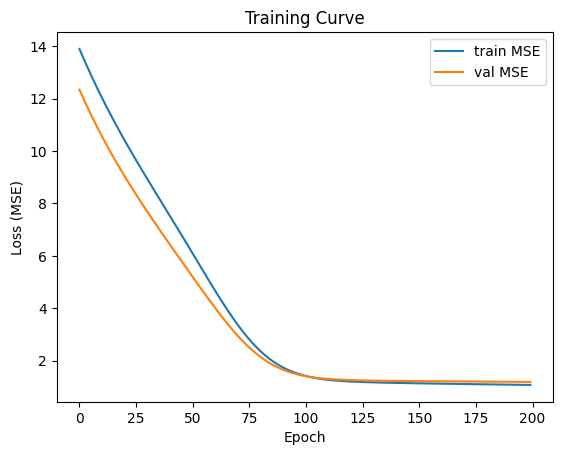

In [214]:
plt.figure()
plt.plot(train_losses, label="train MSE")
if np.isfinite(val_losses).all():
    plt.plot(val_losses, label="val MSE")

plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Curve")
plt.legend()
plt.show()


# Model Predictions vs True Values

Now we’ll evaluate how well the trained neural network predicts molecular solubility (`logS`) on the **validation set**.

### 1️⃣ Scatter Plot
Each point represents one molecule:
- **x-axis** → True experimental solubility (`logS`)
- **y-axis** → Model-predicted solubility
- The **red dashed line** shows *perfect predictions* (where predicted = true).

If the points cluster close to the diagonal line, the model is performing well.

### 2️⃣ Print Example Predictions
We’ll print **five sample molecules** from the validation set to directly compare  
their **true vs predicted solubility values**.

This helps us get a feel for how close the model’s numeric predictions are in real terms.


In [219]:
if X_val_norm.shape[0] > 0:
    y_pred_val, _ = forward(X_val_norm)

    # header
    print(f"{'True logS':>12} | {'Predicted logS':>14}")
    print("-" * 29)

    # print first 5 samples as rows
    for i in range(min(5, len(y_val))):
        print(f"{y_val[i,0]:12.3f} | {y_pred_val[i,0]:14.3f}")
else:
    print("No validation split, skipping evaluation.")


   True logS | Predicted logS
-----------------------------
      -4.660 |         -4.092
      -2.700 |         -3.191
      -3.083 |         -2.991
      -4.560 |         -4.098
      -2.843 |         -2.659


## Discussion

1. Which descriptor do you *think* affects solubility most?
   - MolLogP (hydrophobicity)
   - MolWt
   - NumRotatableBonds (flexibility)
   - AromaticProportion

2. Why did we normalize the features before training?

3. What happens if you:
   - Increase `learning_rate`?
   - Change `hidden_dim` from 8 → 2 or 16?
   - Train for fewer epochs?

4. What is the difference between:
   - Linear regression (no hidden layer, just X -> y)
   - Neural network (we add a hidden layer + nonlinearity ReLU)

5. Can this same pipeline be used to predict toxicity, solubility, boiling point, etc.? (Yes.)
